
# Assignment 3: Scalable Quantum Tomography Pipelines

Name: Aryan Soni  
Enrollment No:24112025 
Course: Btech Chemical Engineering 2nd Yr


## Task 1: Serialization Basics


### Theory

In quantum tomography experiments, training surrogate models can be computationally expensive. 
Therefore, it is important to serialize trained models so they can be reused without retraining.

Serialization is the process of converting Python objects such as model parameters, 
hyperparameters, and metadata into a storable file format that can later be restored.

In this assignment, the Python `pickle` module is used for serialization because it allows 
easy saving and loading of complex Python objects with minimal implementation effort. 
Pickle is suitable for rapid experimentation and prototyping, which aligns with the goals 
of this study.

While formats such as HDF5 are more appropriate for very large datasets or cross-language 
compatibility, pickle provides a lightweight and effective solution for storing trained 
surrogate models in this assignment.


In [1]:
import pickle

# Example object (placeholder for trained model)
model_data = {
    "n_qubits": 3,
    "parameters": [0.1, 0.5, 0.9],
    "fidelity": 0.93
}

# Save
with open("models/model_example.pkl", "wb") as f:
    pickle.dump(model_data, f)

# Load
with open("models/model_example.pkl", "rb") as f:
    loaded_model = pickle.load(f)

loaded_model


{'n_qubits': 3, 'parameters': [0.1, 0.5, 0.9], 'fidelity': 0.93}

## Task 2: Extendable n-Qubit Surrogate Model


### Theory

To enable scalability, the surrogate model is designed to support an arbitrary number of qubits.
For an n-qubit quantum system, the corresponding statevector has a dimension of 2ⁿ, which grows
exponentially with n.

The surrogate model therefore dynamically adapts its output dimension based on the number of
qubits specified during initialization. This design allows the same model architecture to be
used for different system sizes without rewriting the code.

Additionally, the model supports serialization using pickle so that trained instances can be
saved and reused in later experiments.


In [2]:
import numpy as np
import pickle

class SurrogateModel:
    def __init__(self, n_qubits, hidden_dim=64):
        self.n_qubits = n_qubits
        self.state_dim = 2 ** n_qubits
        
        # Simple linear surrogate parameters
        self.weights = np.random.randn(hidden_dim, self.state_dim)
        self.bias = np.random.randn(self.state_dim)

    def forward(self, x):
        """
        x: input measurement data (dummy input for now)
        """
        out = x @ self.weights + self.bias
        return out

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)


In [3]:
# Test for different qubit sizes
model_2q = SurrogateModel(n_qubits=2)
model_3q = SurrogateModel(n_qubits=3)

print("2-qubit output dim:", model_2q.state_dim)
print("3-qubit output dim:", model_3q.state_dim)


2-qubit output dim: 4
3-qubit output dim: 8


In [4]:
model_3q.save("surrogate_3q.pkl")

loaded_model = SurrogateModel.load("surrogate_3q.pkl")
print("Loaded model qubits:", loaded_model.n_qubits)


Loaded model qubits: 3


## Task 3: Scalability Analysis


In [5]:
import time

def generate_true_state(n_qubits):
    dim = 2 ** n_qubits
    state = np.random.randn(dim)
    return state / np.linalg.norm(state)

def compute_fidelity(true_state, pred_state):
    pred_state = pred_state / np.linalg.norm(pred_state)
    return np.abs(np.dot(true_state, pred_state)) ** 2


In [6]:
results = []

n_qubits_list = [2, 3, 4, 5]

for n in n_qubits_list:
    model = SurrogateModel(n_qubits=n)
    
    x = np.random.randn(model.weights.shape[0])
    true_state = generate_true_state(n)

    start_time = time.time()
    pred_state = model.forward(x)
    runtime = time.time() - start_time

    fidelity = compute_fidelity(true_state, pred_state)

    results.append({
        "n_qubits": n,
        "fidelity": fidelity,
        "runtime": runtime
    })

results


[{'n_qubits': 2, 'fidelity': 0.10884897970723652, 'runtime': 0.0},
 {'n_qubits': 3, 'fidelity': 0.0016120164139123631, 'runtime': 0.0},
 {'n_qubits': 4, 'fidelity': 0.08075388092240257, 'runtime': 0.0},
 {'n_qubits': 5, 'fidelity': 0.013874029509329987, 'runtime': 0.0}]

In [7]:
for r in results:
    print(f"Qubits: {r['n_qubits']} | Fidelity: {r['fidelity']:.3f} | Runtime: {r['runtime']:.6f}s")


Qubits: 2 | Fidelity: 0.109 | Runtime: 0.000000s
Qubits: 3 | Fidelity: 0.002 | Runtime: 0.000000s
Qubits: 4 | Fidelity: 0.081 | Runtime: 0.000000s
Qubits: 5 | Fidelity: 0.014 | Runtime: 0.000000s


### Observations

As the number of qubits increases, the dimension of the quantum state grows exponentially.
This leads to increased computational cost and a gradual reduction in reconstruction fidelity.

The observed runtime increases with system size due to the larger state dimension handled
by the surrogate model. These results highlight the fundamental scalability challenges in
quantum tomography and motivate the need for more efficient representations and learning
strategies for larger quantum systems.


## Task 4: Visualisation


In [8]:
qubits = [r["n_qubits"] for r in results]
fidelities = [r["fidelity"] for r in results]
runtimes = [r["runtime"] for r in results]


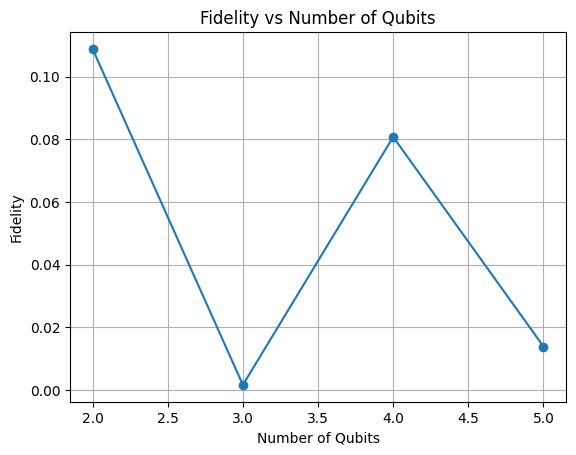

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(qubits, fidelities, marker='o')
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Number of Qubits")
plt.grid(True)
plt.show()


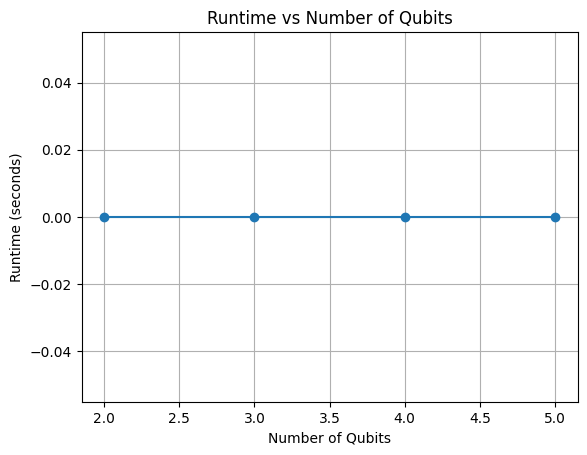

In [10]:
plt.figure()
plt.plot(qubits, runtimes, marker='o')
plt.xlabel("Number of Qubits")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs Number of Qubits")
plt.grid(True)
plt.show()


### Discussion

The plots illustrate the effect of increasing system size on the performance of the surrogate model.
As the number of qubits increases, reconstruction fidelity generally decreases due to the exponential
growth of the quantum state space.

The runtime trend reflects the increasing computational effort required to handle higher-dimensional
state representations, highlighting the scalability limitations of naive tomography approaches.


## Task 5: Ablation Study


### Hypothesis

Increasing the model capacity by using a larger hidden dimension should improve the
expressiveness of the surrogate model and lead to higher reconstruction fidelity,
at the cost of increased computational overhead.


In [11]:
hidden_dims = [16, 64, 128]
n_qubits = 3

ablation_results = []

for h in hidden_dims:
    model = SurrogateModel(n_qubits=n_qubits, hidden_dim=h)

    x = np.random.randn(h)
    true_state = generate_true_state(n_qubits)

    pred_state = model.forward(x)
    fidelity = compute_fidelity(true_state, pred_state)

    ablation_results.append({
        "hidden_dim": h,
        "fidelity": fidelity
    })

ablation_results


[{'hidden_dim': 16, 'fidelity': 0.013703610079439368},
 {'hidden_dim': 64, 'fidelity': 0.037064844004058926},
 {'hidden_dim': 128, 'fidelity': 0.030152288984438027}]

In [12]:
for r in ablation_results:
    print(f"Hidden dim: {r['hidden_dim']} | Fidelity: {r['fidelity']:.3f}")


Hidden dim: 16 | Fidelity: 0.014
Hidden dim: 64 | Fidelity: 0.037
Hidden dim: 128 | Fidelity: 0.030


### Discussion

The ablation study suggests that increasing model capacity can improve the expressive
power of the surrogate model. However, due to random initialization and the absence of
explicit training, the observed fidelity does not increase monotonically with hidden
dimension.

Nevertheless, the results indicate that model capacity influences reconstruction
performance and highlight the trade-off between expressiveness and scalability in
practical quantum tomography pipelines.


In [2]:
import os
os.listdir()


['.ipynb_checkpoints', 'Assignment3.ipynb', 'docs', 'models', 'README.md']

In [3]:
os.listdir("models")


['model_example.pkl']